In [117]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import time
import math

# Votre premier transformer

Nous allons implementer de zero en Pytorch chaque composant d'un transformer 


* Le transformer que nous allons implementer est le transformer original presenté dans le papier "Attention is All you Need." Nous allons implementer au fur et à chaque composant. Le td est en 2 parties : Une partie sur la création d'un transformer, puis une partie sur l'entrainement qui permettra d'entrainer des transformers sur des données textuelles.

![Transformers Architecture](https://i0.wp.com/i.postimg.cc/Bn7QmpQS/1-43lg-CTy-M5c-TTABj-C2-VEHd-A.png?resize=579%2C800&ssl=1)




## Inputs Embeddings

https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html

In [118]:
class InputEmbedding(nn.Module):
    def __init__(self, num_embeddings:int,
                embedding_dim:int):
        
        super(InputEmbedding,self).__init__()
       # TO DO

        self.num_embeddings = num_embeddings
        self.embedding_dim= embedding_dim
        self.input_embeddings = nn.Embedding(num_embeddings,embedding_dim)
        
    def forward(self,x):
        return self.input_embeddings(x)
        

In [119]:
x = torch.randint(20,(10,10))
num_embedding=5000
embedding_dim = 784

token_embedding = InputEmbedding(num_embedding,embedding_dim)
token_embedding(x)

tensor([[[ 0.3982, -0.6401, -0.7175,  ...,  0.7007, -0.7013,  0.3252],
         [ 0.3278,  0.9711, -1.7563,  ..., -1.1424,  0.1104, -1.3900],
         [ 1.1459, -1.1696,  0.7409,  ...,  0.1801,  2.8298, -1.3048],
         ...,
         [ 0.1770,  0.1608,  1.0125,  ...,  0.4637, -0.8548, -0.4498],
         [ 1.4501,  0.8602, -0.0657,  ...,  0.7402, -0.4848, -0.7427],
         [-2.2599, -1.4112, -1.1976,  ..., -1.8756, -0.2930,  1.5682]],

        [[-1.3411,  0.0181, -0.1823,  ...,  1.4571,  0.9370, -1.7317],
         [-0.2431,  0.6883, -0.5443,  ...,  0.0522, -0.5109, -1.4534],
         [ 0.6965,  1.9398,  1.0789,  ..., -0.9459,  1.0437, -0.6712],
         ...,
         [ 0.6965,  1.9398,  1.0789,  ..., -0.9459,  1.0437, -0.6712],
         [-0.2431,  0.6883, -0.5443,  ...,  0.0522, -0.5109, -1.4534],
         [-0.2431,  0.6883, -0.5443,  ...,  0.0522, -0.5109, -1.4534]],

        [[ 0.3072, -0.5479, -1.8639,  ...,  2.6127,  0.2464,  0.6476],
         [ 0.6965,  1.9398,  1.0789,  ..., -0

## Positional Encoding

$$P(k,2i)= sin(\frac{k}{n^{2i/d}})$$
$$P(k,2i+1)= cos(\frac{k}{n^{(2i)/d}})$$
* k : longeur du contexte
* d : taille de l'embedding
* n : 10000 , hyperparamètre
* $i \in [0, d/2]$

In [120]:
class PositionalEmbedding(nn.Module):
    def __init__(self, embedding_dim : int,
                context_length : int,
                user_defined_scalar : int = 10000):
        
        super(PositionalEmbedding,self).__init__()
        
        self.embedding_dim = embedding_dim
        self.context_length = context_length

        self.n = user_defined_scalar
        
        #Intialise positional embedding
        self.positional_embeddings = torch.zeros((self.context_length, self.embedding_dim))
        
        k = torch.arange(self.context_length).unsqueeze(0) # Mettre k sous forme matricielle
        
        i = torch.arange(self.embedding_dim//2)
        
        # Fill the data

        k, i = k.T.repeat(1,self.embedding_dim//2) ,i.repeat(self.context_length,1)

        
        denominator = torch.pow(self.n,2*i/self.embedding_dim)
        
        self.positional_embeddings[:,0::2]=torch.sin(k/(denominator))
        self.positional_embeddings[:,1::2]=torch.cos(k/(denominator))
        
    def forward(self,x):
        return self.positional_embeddings[x,:]
        

In [121]:
def display_positional_embedding(positional_embedding):
    plt.imshow(positional_embedding.positional_embeddings,cmap='viridis')
    plt.show()
    

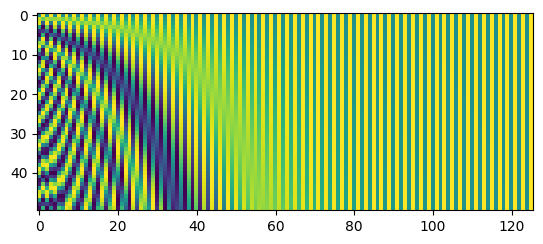

In [122]:
tic = time.time()
pe=PositionalEmbedding(126,50)
toc = time.time()
display_positional_embedding(pe)

## Multihead Attention
![Multi- Head Attention](https://i0.wp.com/i.postimg.cc/G23vwqn4/Screenshot-from-2019-06-17-22-47-53.webp?w=1230&ssl=1)

### Define a simple attention head
* https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
* https://pytorch.org/docs/stable/generated/torch.matmul.html
* https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html

In [123]:
class SelfAttention(nn.Module):
    def __init__(self, embedding_dim: int, hidden_dimension:int, out_dim : int = 0  ):
        super(SelfAttention,self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dimension = hidden_dimension
        
        self.Q = nn.Linear(self.embedding_dim,self.hidden_dimension, bias=False)
        self.K = nn.Linear(self.embedding_dim,self.hidden_dimension, bias= False)
        self.out_dim = out_dim
        if out_dim ==0 : 
            self.out_dim = self.embedding_dim
        
            
        self.V = nn.Linear(self.embedding_dim,self.out_dim,bias=False)
    def forward(self,x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (embedding_dim)
        
        q = self.Q(x)
        k = self.K(x)
        v = self.V(x)
        
        attention = torch.matmul(q,k.transpose(-2,-1))/math.sqrt(self.hidden_dimension)
        attention = F.softmax(attention, dim=-1)

        out = torch.matmul(attention,v)

        return out, attention

In [124]:
x = torch.rand((11,10,784))
sa_module = SelfAttention(784,10)
out, attention = sa_module(x)
out.shape , attention.shape
attention

tensor([[[0.0971, 0.0974, 0.1023,  ..., 0.0974, 0.0952, 0.1040],
         [0.1010, 0.0889, 0.1054,  ..., 0.0969, 0.1005, 0.1002],
         [0.0965, 0.0979, 0.1023,  ..., 0.0977, 0.0938, 0.1072],
         ...,
         [0.0996, 0.0952, 0.1012,  ..., 0.0961, 0.1002, 0.1030],
         [0.0977, 0.0955, 0.1008,  ..., 0.0929, 0.0997, 0.1044],
         [0.1000, 0.0962, 0.0974,  ..., 0.0948, 0.1009, 0.1043]],

        [[0.0982, 0.1017, 0.0977,  ..., 0.0964, 0.0982, 0.1070],
         [0.0960, 0.1001, 0.0959,  ..., 0.1024, 0.0982, 0.1115],
         [0.0957, 0.1013, 0.0971,  ..., 0.0969, 0.1004, 0.1084],
         ...,
         [0.0960, 0.1019, 0.1013,  ..., 0.0947, 0.1002, 0.1059],
         [0.0977, 0.1020, 0.0974,  ..., 0.0952, 0.0995, 0.1055],
         [0.0979, 0.1007, 0.1009,  ..., 0.0960, 0.1001, 0.1033]],

        [[0.1011, 0.1108, 0.1055,  ..., 0.0978, 0.0964, 0.0934],
         [0.1058, 0.1031, 0.0958,  ..., 0.0993, 0.0992, 0.0970],
         [0.1017, 0.1132, 0.0996,  ..., 0.0987, 0.1006, 0.

### Masked MultiHead Attention
* https://pytorch.org/docs/stable/generated/torch.Tensor.masked_fill_.html
* https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html

In [125]:
class MaskedSelfAttention(SelfAttention):
    def __init__(self, embedding_dim: int, hidden_dimension:int,out_dim : int = 0  ):
        super(MaskedSelfAttention,self).__init__(embedding_dim,hidden_dimension,out_dim)
        # self.embedding_dim = embedding_dim
        # self.hidden_dimension = hidden_dimension
        
        # self.Q = nn.Linear(self.embedding_dim,self.hidden_dimension, bias=False)
        # self.K = nn.Linear(self.embedding_dim,self.hidden_dimension, bias= False)
        # self.V = nn.Linear(self.embedding_dim,self.embedding_dim,bias=False)
        
    def forward(self,x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (embedding_dim)
        
        q = self.Q(x)
        k = self.K(x)
        v = self.V(x)
        
        mask= torch.tril(torch.ones(B,T,T))
        mask = mask.to(x.device)

        attention = torch.matmul(q,k.transpose(-2,-1))/math.sqrt(self.hidden_dimension)

        attention = attention.masked_fill(mask ==0 , float("-inf"))

        attention = F.softmax(attention, dim=-1)

        out = torch.matmul(attention,v)

        return out, attention

In [126]:
x = torch.rand((11,10,784))
sa_module = MaskedSelfAttention(784,10)
out, attention = sa_module(x)
out.shape , attention.shape
attention

tensor([[[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.5066, 0.4934, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.3360, 0.3287, 0.3352,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1351, 0.1245, 0.1221,  ..., 0.1265, 0.0000, 0.0000],
         [0.1108, 0.1116, 0.1106,  ..., 0.1100, 0.1122, 0.0000],
         [0.0998, 0.1002, 0.0986,  ..., 0.1007, 0.1036, 0.0988]],

        [[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.4854, 0.5146, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.3211, 0.3475, 0.3314,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1249, 0.1234, 0.1209,  ..., 0.1189, 0.0000, 0.0000],
         [0.1071, 0.1115, 0.1066,  ..., 0.1065, 0.1130, 0.0000],
         [0.0930, 0.1021, 0.0929,  ..., 0.0982, 0.1031, 0.1080]],

        [[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.4833, 0.5167, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.3175, 0.3201, 0.3623,  ..., 0.0000, 0.0000, 0.

### Define multihead attention

In [127]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim : int , n_head :int, hidden_dimension : int ):
        super(MultiHeadAttention, self).__init__()
        self.n_head = n_head
        self.projector = nn.Linear(embedding_dim,embedding_dim)
        self.hidden_dimension = hidden_dimension
        self.heads = nn.ModuleList([SelfAttention(embedding_dim,self.hidden_dimension, out_dim= embedding_dim//n_head) for i in range(self.n_head)])
        
    def forward(self,x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (embedding_dim)
        
        int_outs = []
        int_attentions = []
        for head in self.heads:
            out, attn = head(x)
            int_attentions.append(attn)
            int_outs.append(out)
        out = torch.concatenate(int_outs,dim=-1)
        out = self.projector(out)
        out_attention = torch.stack(int_attentions,dim = 1)
        return out , out_attention
            
            

In [128]:
embedding_dim = 784
n_heads = 4
hidden_dimension = 784
context_lenght = 10
bs = 11
mha = MultiHeadAttention(embedding_dim,n_heads,hidden_dimension)
x = torch.rand((bs,context_lenght,embedding_dim))
out, attention = mha(x)
out.shape , attention.shape

(torch.Size([11, 10, 784]), torch.Size([11, 4, 10, 10]))

## Masked Multihead Attention

In [129]:
class MaskedMultiHeadAttention(MultiHeadAttention):
    def __init__(self, embedding_dim : int , n_head :int, hidden_dimension : int ):
        super(MaskedMultiHeadAttention, self).__init__(embedding_dim,n_head,hidden_dimension)
        self.heads = nn.ModuleList([MaskedSelfAttention(embedding_dim,self.hidden_dimension, out_dim= embedding_dim//n_head) for i in range(self.n_head)])

In [130]:
embedding_dim = 784
n_heads = 16
hidden_dimension = 784
context_lenght = 10
bs = 11
mha = MaskedMultiHeadAttention(embedding_dim,n_heads,hidden_dimension)
x = torch.rand((bs,context_lenght,embedding_dim))
out, attention = mha(x)
out.shape , attention.shape

(torch.Size([11, 10, 784]), torch.Size([11, 16, 10, 10]))

## Cross MultiHead Attention

In [131]:
class CrossAttention(nn.Module):
    def __init__(self, embedding_dim: int, hidden_dimension:int, out_dim : int = 0  ):
        super(CrossAttention,self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dimension = hidden_dimension
        
        self.Q = nn.Linear(self.embedding_dim,self.hidden_dimension, bias=False)
        self.K = nn.Linear(self.embedding_dim,self.hidden_dimension, bias= False)
        self.out_dim = out_dim
        if out_dim ==0 : 
            self.out_dim = self.embedding_dim
        
            
        self.V = nn.Linear(self.embedding_dim,self.out_dim,bias=False)
    def forward(self, x , context):
        B_dec, T_dec, C__dec = x.size() # batch size, sequence length, embedding dimensionality (embedding_dim)
        B, T, C = context.size() # batch size, sequence length, embedding dimensionality (embedding_dim)
        
        q = self.Q(x)
        k = self.K(context)
        v = self.V(context)
        
        attention = torch.matmul(q,k.transpose(-2,-1))/math.sqrt(self.hidden_dimension)
        attention = F.softmax(attention, dim=-1)

        out = torch.matmul(attention,v)

        return out, attention

In [132]:
class CrossMultiHeadAttention(MultiHeadAttention):
    def __init__(self, embedding_dim : int , n_head :int, hidden_dimension : int ):
        super(CrossMultiHeadAttention, self).__init__(embedding_dim,n_head,hidden_dimension)
        self.heads = nn.ModuleList([CrossAttention(embedding_dim,self.hidden_dimension, out_dim= embedding_dim//n_head) for i in range(self.n_head)])
        
    def forward(self,x,context):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (embedding_dim)
        
        int_outs = []
        int_attentions = []
        for head in self.heads:
            out, attn = head(x,context)
            int_attentions.append(attn)
            int_outs.append(out)
        out = torch.concatenate(int_outs,dim=-1)
        out = self.projector(out)
        out_attention = torch.stack(int_attentions,dim = 1)
        return out , out_attention

In [133]:
embedding_dim = 784
n_heads = 16
hidden_dimension = 784
context_lenght = 10
bs = 11
cha = CrossMultiHeadAttention(embedding_dim,n_heads,hidden_dimension)
x = torch.rand((bs,context_lenght,embedding_dim))
context = torch.rand((bs,context_lenght//2,embedding_dim))
out, attention = cha(x,context)
out.shape , attention.shape

(torch.Size([11, 10, 784]), torch.Size([11, 16, 10, 5]))



## Feed Forward Layer

In [134]:
class FeedForward(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(embedding_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, embedding_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))


## Block

In [135]:
class EncoderBlock(nn.Module):
    def __init__(self, embedding_dim: int,
                 qk_hidden_dimension:int,
                 feedforward_hidden_dimension : int,
                 n_heads : int   ):
        super(EncoderBlock, self).__init__()
        
        self.n_heads = n_heads
        self.embedding_dim = embedding_dim
        self.qk_hidden_dimension = qk_hidden_dimension
        self.feedforward_hidden_dimension = feedforward_hidden_dimension
        self.multiHeadAttention = MultiHeadAttention(self.embedding_dim,self.n_heads,self.qk_hidden_dimension)
        self.feed_forward= FeedForward(self.embedding_dim, self.feedforward_hidden_dimension)
        self.layer_norm1 = nn.LayerNorm(self.embedding_dim)
        self.layer_norm2 = nn.LayerNorm(self.embedding_dim)
        
    def forward(self,x):
        x1,att1 = self.multiHeadAttention(x)
        x1 = x + self.layer_norm1(x1)
        x1 = self.feed_forward(x1)
        out = x1 + self.layer_norm2(x1)
        return out, att1
        
        

In [136]:
embedding_dim = 784
n_heads = 16
hidden_dimension = 784
context_lenght = 10
bs = 11
n_blocks  = 5
vocab_size = 3000
context_size = 40
enc_bloc = EncoderBlock(embedding_dim,hidden_dimension,hidden_dimension,n_heads)
x = torch.rand((bs,context_lenght,embedding_dim))
enc , attn = enc_bloc(x)
enc.shape , attn.shape

(torch.Size([11, 10, 784]), torch.Size([11, 16, 10, 10]))

## Encoder

In [137]:
class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim: int,
                 qk_hidden_dimension:int,
                 feedforward_hidden_dimension : int,
                 n_heads : int ,
                n_blocks : int,
                vocab_size : int,
                context_size : int):
        super(TransformerEncoder, self).__init__()
        
        self.pe = PositionalEmbedding(embedding_dim,context_size)
        self.te = InputEmbedding( vocab_size , embedding_dim)
        self.blocks = nn.ModuleList([EncoderBlock(embedding_dim,
                                                  qk_hidden_dimension,
                                                  feedforward_hidden_dimension,
                                                  n_heads) for i in range(n_blocks)])
    def forward(self,x):
        B, T = x.size() # batch size, sequence length
        attns = []
        pos_x = torch.arange(T).unsqueeze(0).repeat(B,1)
        x_emb = self.pe(pos_x)+self.te(x)
        for block in self.blocks:
            x_emb , attn = block(x_emb)
            attns.append(attn)
        return x_emb , attns
                                    
                                               

In [138]:
encoder = TransformerEncoder(embedding_dim,hidden_dimension,hidden_dimension,n_heads,n_blocks,vocab_size, context_size)
x = torch.randint(20,(10,25))
encoding , attns = encoder(x)
encoding.shape , len(attns), attns[0].shape

(torch.Size([10, 25, 784]), 5, torch.Size([10, 16, 25, 25]))

## Decoder

# A vous de jouer

En reutilisant au maximum les composants au dessus, implementer le decodeur et le transformeur final

## Transformer

